In [1]:
import blaze as bz
import numpy as np
import pandas as pd
import sqlite3
import itertools

from zipline.data import bundles
from zipline.utils.calendars import get_calendar

from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.data import DataSet
from zipline.pipeline.engine import SimplePipelineEngine
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.blaze import BlazeLoader, from_blaze


trading_calendar = get_calendar('NYSE')
bundle_data = bundles.load('quandl')

# spoof some data

np.random.seed(100)

start = trading_calendar.closes.index.get_loc('2016-01-04 00:00:00+00:00')
end = trading_calendar.closes.index.get_loc('2018-08-06 00:00:00+00:00')

#dates = list(trading_calendar.closes.index)[start:end]
dates = trading_calendar.closes.index[start:end]
sids = bundle_data.asset_finder.sids

df = pd.DataFrame(
    data={'value': np.random.random(size=len(dates)*len(sids))},
    index = pd.MultiIndex.from_tuples(list(itertools.product(dates,sids)), names=('asof_date', 'sid'))
)

/anaconda3/envs/py27/lib/python2.7/site-packages/odo/backends/pandas.py:94: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access NaTType as type(pandas.NaT)
  @convert.register((pd.Timestamp, pd.Timedelta), (pd.tslib.NaTType, type(None)))


In [2]:
df = df.reset_index()

In [3]:
# this is necessary because sqlite3 doesn't like it if we have the time
df.asof_date = df.asof_date.dt.date

In [4]:
df.head()

,asof_date,sid,value
0,2016-01-04,0,0.543405
1,2016-01-04,1,0.278369
2,2016-01-04,2,0.424518
3,2016-01-04,3,0.844776
4,2016-01-04,4,0.004719


In [5]:
# put into sqlite db
df.to_sql('ds_table', con=sqlite3.connect('temp.db'), if_exists='replace', index=False)

In [6]:
con = sqlite3.connect('temp.db')
cursor = con.cursor()
cursor.execute("SELECT * FROM ds_table LIMIT 10")
print(cursor.fetchall())

[(u'2016-01-04', 0, 0.5434049417909654), (u'2016-01-04', 1, 0.27836938509379616), (u'2016-01-04', 2, 0.4245175907491331), (u'2016-01-04', 3, 0.8447761323199037), (u'2016-01-04', 4, 0.004718856190972565), (u'2016-01-04', 5, 0.12156912078311422), (u'2016-01-04', 6, 0.6707490847267786), (u'2016-01-04', 7, 0.8258527551050476), (u'2016-01-04', 8, 0.13670658968495297), (u'2016-01-04', 9, 0.57509332942725)]


In [7]:
from datashape import dshape

In [19]:
ds_dshape = dshape("var*{asof_date: datetime, sid: int64, value: float64}")

In [20]:
ds_dshape

dshape("var * {asof_date: datetime, sid: int64, value: float64}")

In [21]:
# create the blaze expr

expr = bz.Data(
    'sqlite:///temp.db::ds_table',
    dshape=ds_dshape
)

In [22]:
expr.dshape

dshape("var * {asof_date: ?date, sid: ?int32, value: ?float32}")

In [15]:
expr.peek()

,asof_date,sid,value
0,2016-01-04,0,0.543405
1,2016-01-04,1,0.278369
2,2016-01-04,2,0.424518
3,2016-01-04,3,0.844776
4,2016-01-04,4,0.004719
5,2016-01-04,5,0.121569
6,2016-01-04,6,0.670749
7,2016-01-04,7,0.825853
8,2016-01-04,8,0.136707
9,2016-01-04,9,0.575093


In [16]:
expr.schema

dshape("{asof_date: ?date, sid: ?int32, value: ?float32}")

In [17]:
# create and empty BlazeLoader
my_blaze_loader = BlazeLoader()

# create the DataSet
ds = from_blaze(
    expr,
    no_deltas_rule='ignore',
    no_checkpoints_rule='ignore',
    loader=my_blaze_loader,
    missing_values={'index':-1}
)

TypeError: 'asof_date' field must be a 'datetime', not: '?date'

In [10]:
issubclass(ds, DataSet)

NameError: name 'ds' is not defined

In [11]:
my_blaze_loader

<BlazeLoader: {<DataSet: 'BlazeDataSet_0'>: ExprData(expr="Merge(_child=_1, children=(_1, label(_1.asof_date, 'timestamp')))", deltas='None', checkpoints='None', odo_kwargs={}, apply_deltas_adjustments=True)}>

In [12]:
pipeline_loader = USEquityPricingLoader(
    bundle_data.equity_daily_bar_reader,
    bundle_data.adjustment_reader,
)

In [13]:
def choose_loader(column):
    if column in USEquityPricing.columns:
        return pipeline_loader
    else:
        return my_blaze_loader

In [14]:
engine = SimplePipelineEngine(
    get_loader=choose_loader,
    calendar=trading_calendar.all_sessions,
    asset_finder=bundle_data.asset_finder,
)

In [15]:
assets = bundle_data.asset_finder.lookup_symbols(['A', 'AAL'], as_of_date=None)

In [16]:
p = Pipeline(
    columns={
        'price': USEquityPricing.close.latest,
        'col_A': ds.value.latest,
    },
    screen=StaticAssets(assets)
)

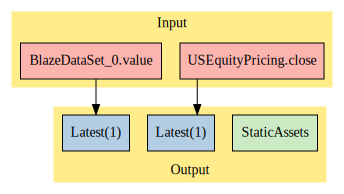

In [17]:
p.show_graph()

In [18]:
df = engine.run_pipeline(
    p,
    pd.Timestamp('2016-01-05', tz='utc'),
    pd.Timestamp('2018-01-04', tz='utc')
)

In [20]:
df.head()

col_A  price
2016-01-05 00:00:00+00:00 Equity(0 [A])    0.909776  40.69
                          Equity(2 [AAL])  0.913870  40.91
2016-01-06 00:00:00+00:00 Equity(0 [A])    0.326422  40.55
                          Equity(2 [AAL])  0.039638  40.52
2016-01-07 00:00:00+00:00 Equity(0 [A])    0.486700  40.73

In [30]:
import blaze as bz
from datashape import dshape
import numpy as np
import pandas as pd
import sqlite3

In [25]:
np.random.seed(100)

start = pd.Timestamp('2015-01-01')
end = pd.Timestamp('2015-12-31')
dates = pd.date_range(start, end)
sids = np.arange(0, 100)

df = pd.DataFrame(
    data={'value': np.random.random(size=len(dates)*len(sids))},
    index = pd.MultiIndex.from_tuples(list(itertools.product(dates,sids)), names=('asof_date', 'sid'))
)

In [27]:
df = df.reset_index()

In [28]:
df.head()

,asof_date,sid,value
0,2015-01-01,0,0.543405
1,2015-01-01,1,0.278369
2,2015-01-01,2,0.424518
3,2015-01-01,3,0.844776
4,2015-01-01,4,0.004719


In [29]:
df.to_sql('my_table', con=sqlite3.connect('temp.db'), if_exists='replace', index=False)

In [37]:
my_dshape = dshape("var*{asof_date: datetime, sid: int64, value: float64}")

In [38]:
expr = bz.Data(
    'sqlite:///temp.db::my_table',
    dshape=my_dshape
)

In [39]:
expr.dshape

dshape("var * {asof_date: ?datetime, sid: ?int32, value: ?float32}")

In [40]:
!pip freeze

alembic==0.7.7
alphalens==0.3.2
-e git+https://marketneutral@github.com/marketneutral/alphatools.git@458bc866f5a31978986e2cdf49b4f2cf8f54aa87#egg=alphatools
appnope==0.1.0
asn1crypto==0.24.0
backports-abc==0.5
backports.functools-lru-cache==1.5
backports.shutil-get-terminal-size==1.0.0
bcolz==0.12.1
blaze==0.10.1
Bottleneck==1.2.1
certifi==2018.8.13
cffi==1.11.5
chardet==3.0.4
click==6.7
contextlib2==0.5.5
cryptography==2.3.1
cryptography-vectors==2.3.1
-e git+https://marketneutral@github.com/marketneutral/cvxportfolio.git@152188adac72c1bce85f1aa526e85b4f611cf497#egg=cvxportfolio
cvxpy==1.0.8
cycler==0.10.0
cyordereddict==0.2.2
Cython==0.28.5
datashape==0.5.2
decorator==4.3.0
dill==0.2.8.2
ecos==2.0.5
empyrical==0.5.0
enum34==1.1.6
fastcache==1.0.2
Flask==1.0.2
Flask-Cors==3.0.6
future==0.16.0
futures==3.2.0
idna==2.7
intervaltree==2.1.0
ipaddress==1.0.22
ipykernel==4.8.2
ipython==5.8.0
ipython-genutils==0.2.0
itsdangerous==0.24
Jinja2==2.10
jupyter-client==5.2.3
jupyter-core==4.4.0
ki

In [44]:
con = sqlite3.connect('temp.db')
cursor = con.cursor()
cursor.execute("SELECT * FROM my_table LIMIT 3")
cursor.fetchall()

[(u'2015-01-01 00:00:00', 0, 0.5434049417909654),
 (u'2015-01-01 00:00:00', 1, 0.27836938509379616),
 (u'2015-01-01 00:00:00', 2, 0.4245175907491331)]

In [42]:
cursor.execute("PRAGMA table_info('my_table')").fetchall()

[(0, u'asof_date', u'TIMESTAMP', 0, None, 0),
 (1, u'sid', u'INTEGER', 0, None, 0),
 (2, u'value', u'REAL', 0, None, 0)]